# Title

## Introduction

## Result

#### Data Preparation
The dataset is obtained from https://geodash.vpd.ca/opendata/# \
Unfortunately, VPD didn't provide their datasets a URL for direct download into JupyterHub, so we first manually downloaded and stored the dataset to GoogleDrive then generated downloadable URL from there. 

In [1]:
library(tidyverse)
library(infer)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
URL2017 <- "https://drive.google.com/uc?id=11RimvDwqEXhi88RdmiHg6PUGOL8xXMW4&export=download"
URL2018 <- "https://drive.google.com/uc?id=1vA-vnvTlHoXV1q6bu4S_qay37nz7X3UM&export=download"
URL2019 <- "https://drive.google.com/uc?id=1kBSEJl-JCIzqzVmB9PMLZ-C2WM1hH7je&export=download"
URL2020 <- "https://drive.google.com/uc?id=1zaTH_62fMJNYMjWItzjSvrK3nKdK74Zn&export=download"
URL2021 <- "https://drive.google.com/uc?id=1Inz166gXuGusb47PhV6nQMEpxpl4Wh92&export=download"
URL2022 <- "https://drive.google.com/uc?id=1vUUblkLnMKSxb8S0y55Zi3IHjfIZOJ2N&export=download"
cr2017 <- read.csv(URL2017)
cr2018 <- read.csv(URL2018)
cr2019 <- read.csv(URL2019)
cr2020 <- read.csv(URL2020)
cr2021 <- read.csv(URL2021)
cr2022 <- read.csv(URL2022)

In [3]:
# combine 6 years into one dataframe
cr2017_2022 <- rbind(cr2017,cr2018,cr2019,cr2020,cr2021,cr2022)
head(cr2017_2022)

# only select the TYPE, YEAR, NEIGHBOURHOOD for analysis
crime2017_2022 <- cr2017_2022 %>% 
    select(TYPE, YEAR, MONTH, DAY, NEIGHBOURHOOD) 
head(crime2017_2022)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Theft of Vehicle,2017,11,29,20,0,29XX SKEENA ST,Renfrew-Collingwood,497919.2,5456148
2,Theft of Vehicle,2017,6,21,21,0,2X JACKSON AVE,Strathcona,493220.8,5459096
3,Theft of Vehicle,2017,9,21,18,0,2X W 14TH AVE,Mount Pleasant,492319.5,5456190
4,Theft of Vehicle,2017,5,9,15,30,2X W PENDER ST,Central Business District,492338.0,5458667
5,Theft of Vehicle,2017,10,9,6,0,2XX ALEXANDER ST,Strathcona,492802.5,5459038
6,Theft of Vehicle,2017,6,13,6,45,2XX CENTRAL ST,Strathcona,492756.6,5457623


,TYPE,YEAR,MONTH,DAY,NEIGHBOURHOOD
,<chr>,<int>,<int>,<int>,<chr>
1,Theft of Vehicle,2017,11,29,Renfrew-Collingwood
2,Theft of Vehicle,2017,6,21,Strathcona
3,Theft of Vehicle,2017,9,21,Mount Pleasant
4,Theft of Vehicle,2017,5,9,Central Business District
5,Theft of Vehicle,2017,10,9,Strathcona
6,Theft of Vehicle,2017,6,13,Strathcona


#### Preliminary Analysis

In [4]:
# overal daily total crime incidents for each neighborhood in each year
crime_total <- crime2017_2022 %>%
    group_by(YEAR, MONTH, DAY, NEIGHBOURHOOD) %>%
    filter(NEIGHBOURHOOD != "") %>%
    summarise(total = n(), `.groups` = "drop")
head(crime_total)

YEAR,MONTH,DAY,NEIGHBOURHOOD,total
<int>,<int>,<int>,<chr>,<int>
2017,1,1,Arbutus Ridge,1
2017,1,1,Central Business District,27
2017,1,1,Dunbar-Southlands,1
2017,1,1,Fairview,5
2017,1,1,Grandview-Woodland,7
2017,1,1,Hastings-Sunrise,8


In [5]:
# daily analysis 
# daily average crime incidents for each neighborhood in each year
crime_daily_avg <- crime_total %>%
    group_by(NEIGHBOURHOOD) %>%
    summarise(daily_avg = mean(total))
head(crime_daily_avg)

# daily median  for crime incidents for each neighborhood in each year
crime_daily_median <- crime_total %>%
    group_by(NEIGHBOURHOOD) %>%
    summarise(daily_median = median(total))
head(crime_daily_median)

# daily standard deviation for crime incidents for each neighborhood in each year
crime_daily_sd <- crime_total %>%
    group_by(NEIGHBOURHOOD) %>%
    summarise(daily_sd = sd(total))
head(crime_daily_sd)

NEIGHBOURHOOD,daily_avg
<chr>,<dbl>
Arbutus Ridge,1.715462
Central Business District,34.395324
Dunbar-Southlands,1.933172
Fairview,5.937701
Grandview-Woodland,5.739270
Hastings-Sunrise,3.978830


NEIGHBOURHOOD,daily_median
<chr>,<dbl>
Arbutus Ridge,1
Central Business District,34
Dunbar-Southlands,2
Fairview,6
Grandview-Woodland,5
Hastings-Sunrise,4


NEIGHBOURHOOD,daily_sd
<chr>,<dbl>
Arbutus Ridge,1.017479
Central Business District,11.678437
Dunbar-Southlands,1.177089
Fairview,2.997830
Grandview-Woodland,2.880449
Hastings-Sunrise,2.252361


In [6]:
# monthly analysis
# monthly average crime incidents per day for all neighbourhoods
crime_monthly_avg <- crime_total %>%
    group_by(YEAR,MONTH) %>%
    summarise(monthly_avg = mean(total), `.groups` = "drop")
#head(crime_monthly_avg)

# monthly median crime incidents per day for all neighbourhoods
crime_monthly_median <- crime_total %>%
    group_by(YEAR,MONTH) %>%
    summarise(monthly_median = median(total), `.groups` = "drop")
#head(crime_monthly_median)

# monthly standard deviation crime incidents per day for all neighbourhoods
crime_monthly_sd <- crime_total %>%
    group_by(YEAR,MONTH) %>%
    summarise(monthly_sd = sd(total), `.groups` = "drop")
#head(crime_monthly_sd)

summary_stats_on_month <- cbind(crime_monthly_median,crime_monthly_avg,crime_monthly_sd)%>%
    select(-c(4,5,7,8))

head(summary_stats_on_month)

,YEAR,MONTH,monthly_median,monthly_avg,monthly_sd
,<int>,<int>,<dbl>,<dbl>,<dbl>
1,2017,1,3,4.962329,6.883890
2,2017,2,3,5.360000,7.277352
3,2017,3,4,5.799012,7.663022
4,2017,4,3,5.776094,7.941525
5,2017,5,4,6.053245,8.014185
6,2017,6,4,5.921311,7.880910


In [7]:
# highest average daily cirme incident rate
daily_highest <- max(crime_daily_avg$daily_avg)
highest_area <- crime_daily_avg$NEIGHBOURHOOD[which.max(crime_daily_avg$daily_avg)]
daily_highest
highest_area

# lowest average daily cirme incident rate
daily_lowest <- min(crime_daily_avg$daily_avg)
lowest_area <- crime_daily_avg$NEIGHBOURHOOD[which.min(crime_daily_avg$daily_avg)]
daily_lowest
lowest_area

[1] 34.39532

[1] "Central Business District"

[1] 1.140845

[1] "Musqueam"

#### Inferential Analysis

#### Asymptotic 

In [8]:
# CLT with sample size 500
set.seed(30)
pop_mu <- mean(crime_total$total)
pop_sd <- sd(crime_total$total)


sample_500 <- crime_total %>%
    rep_sample_n(size = 500, reps = 10000, replace = FALSE) %>%
    group_by(DAY, replicate) %>% 
    summarise(sample_mean = mean(total), `.groups` = "drop")
head(sample_500)

data_normal <- tibble(total=seq(min(crime_total$total), 
                                max(crime_total$total),0.01), 
                                density = dnorm(total, pop_mu, pop_sd))

DAY,replicate,sample_mean
<int>,<int>,<dbl>
1,1,5.666667
1,2,3.583333
1,3,4.166667
1,4,10.500000
1,5,5.125000
1,6,7.533333


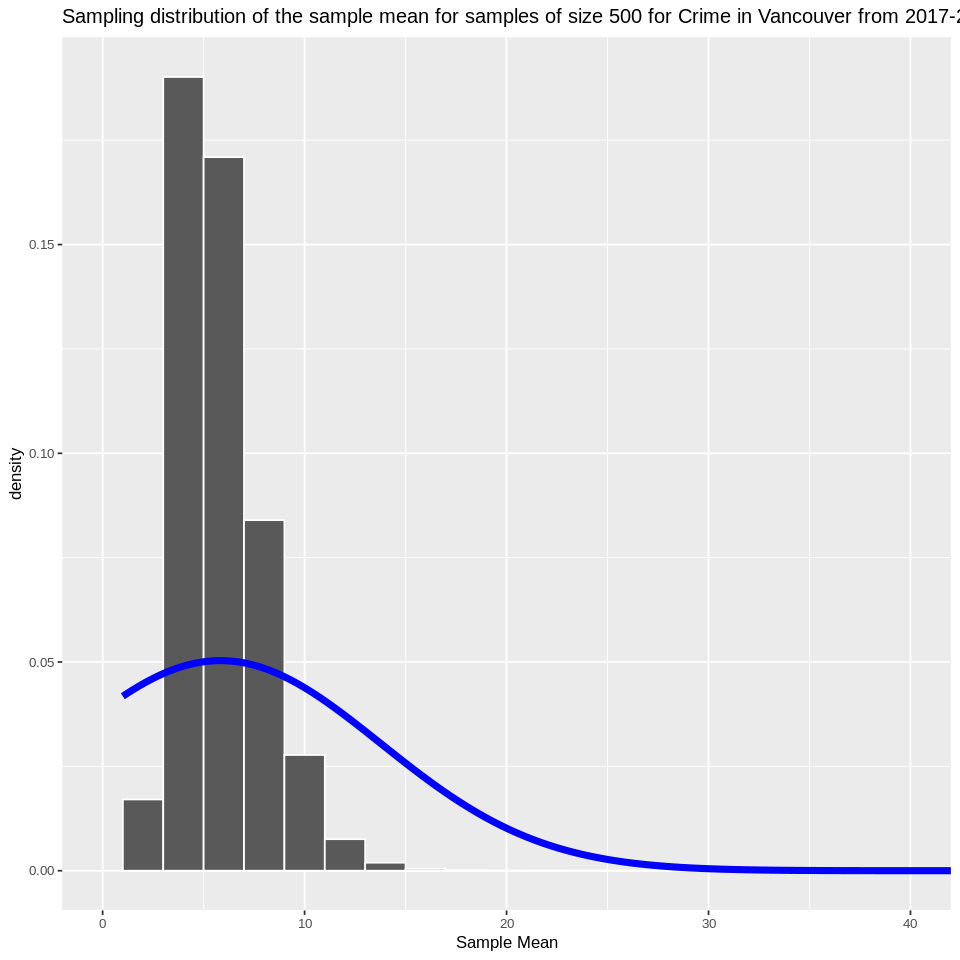

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)
sampling_dist_500 <- sample_500 %>% 
    ggplot() + 
    geom_histogram(aes(x = sample_mean, y = ..density..), binwidth = 2, color="white") +
    theme(text = element_text(size = 10))+
    xlab("Sample Mean") +
    ggtitle("Sampling distribution of the sample mean for samples of size 500 for Crime in Vancouver from 2017-2022.") + 
    geom_line(data = data_normal, aes(total, density), color = "blue", lwd = 2)+
    coord_cartesian(xlim=c(0,40))
sampling_dist_500

#### Bootstrapping

In [10]:
# Bootstrap with sample size 500
set.seed(31)
one_sample <- crime_total %>%
    rep_sample_n(size = 500, reps = 1, replace = FALSE)
boot_500 <- one_sample %>%
    rep_sample_n(size = 500, reps = 10000, replace = TRUE) %>%
    group_by(DAY, replicate) %>% 
    summarise(sample_mean = mean(total), `.groups` = "drop")
head(boot_500)

DAY,replicate,sample_mean
<int>,<int>,<dbl>
1,1,3.187500
1,2,5.764706
1,3,6.214286
1,4,5.000000
1,5,4.692308
1,6,4.421053


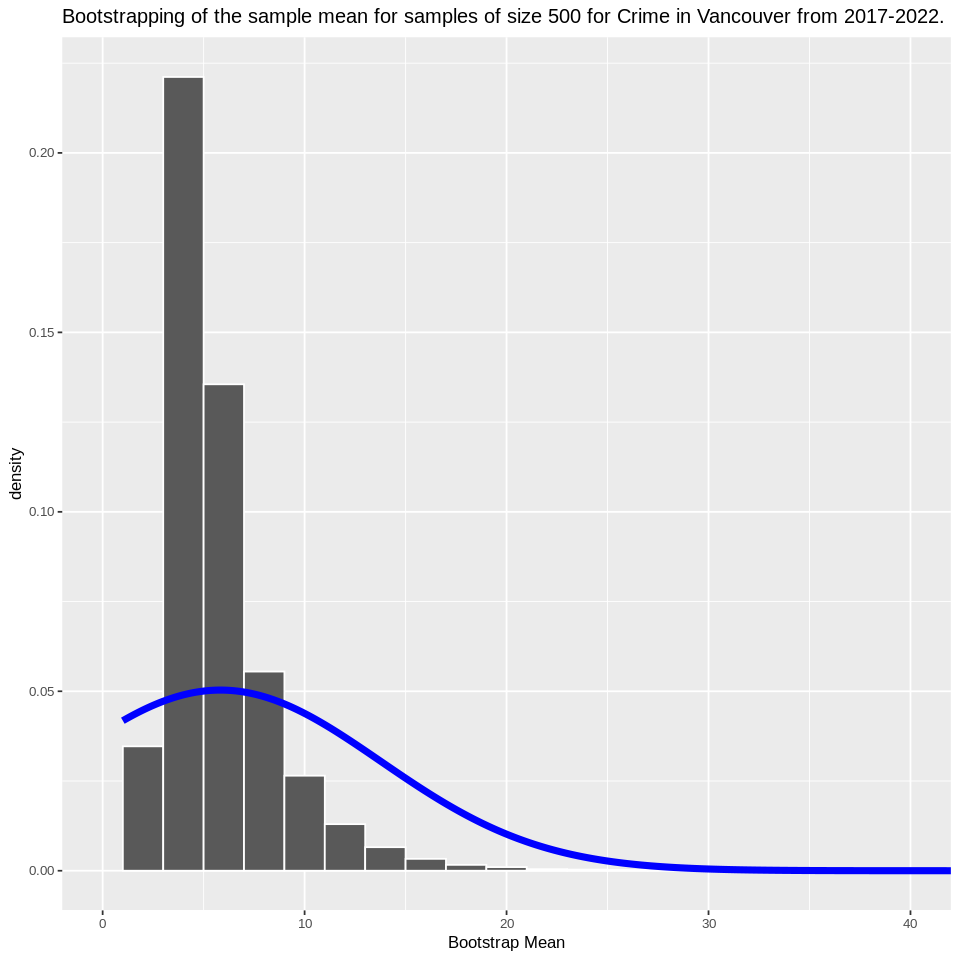

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8)
bootstrap_500 <- boot_500 %>% 
    ggplot() + 
    geom_histogram(aes(x = sample_mean, y = ..density..), binwidth = 2, color="white") +
    theme(text = element_text(size = 10))+
    xlab("Bootstrap Mean") +
    ggtitle("Bootstrapping of the sample mean for samples of size 500 for Crime in Vancouver from 2017-2022.") + 
    geom_line(data = data_normal, aes(total, density), color = "blue", lwd = 2)+
    coord_cartesian(xlim=c(0,40))
bootstrap_500

#### Visualization

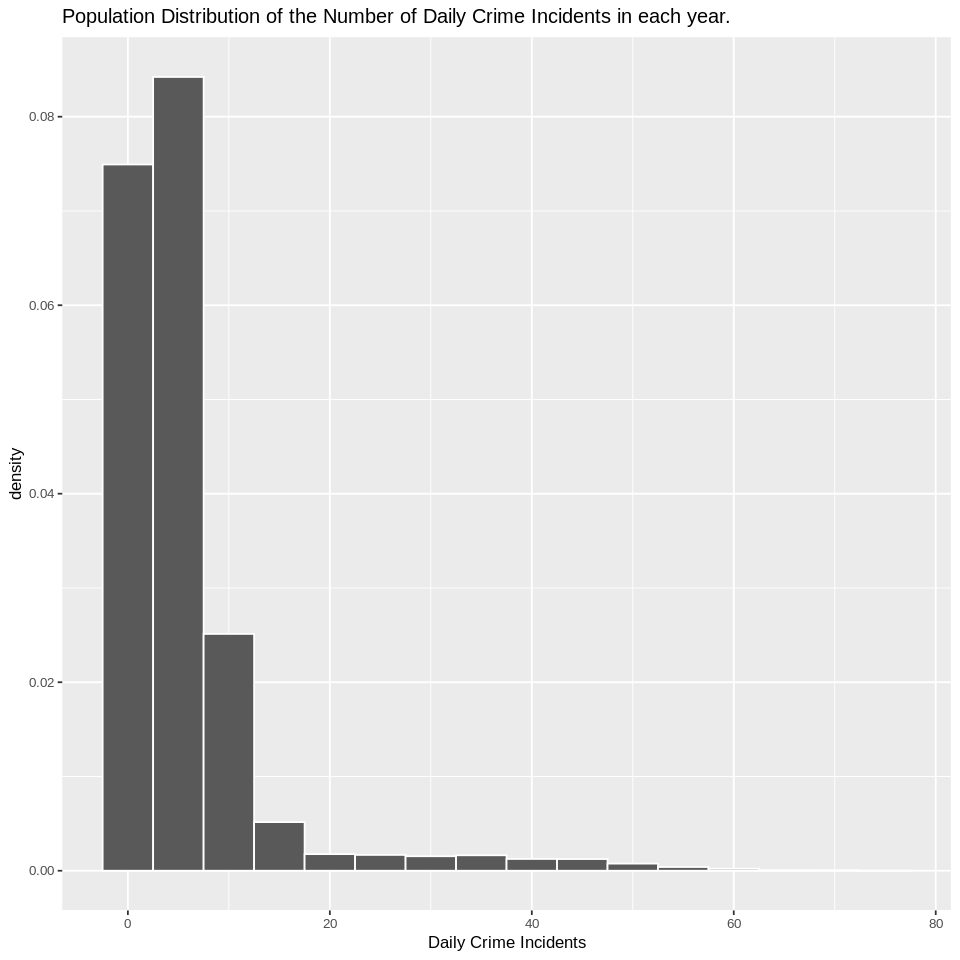

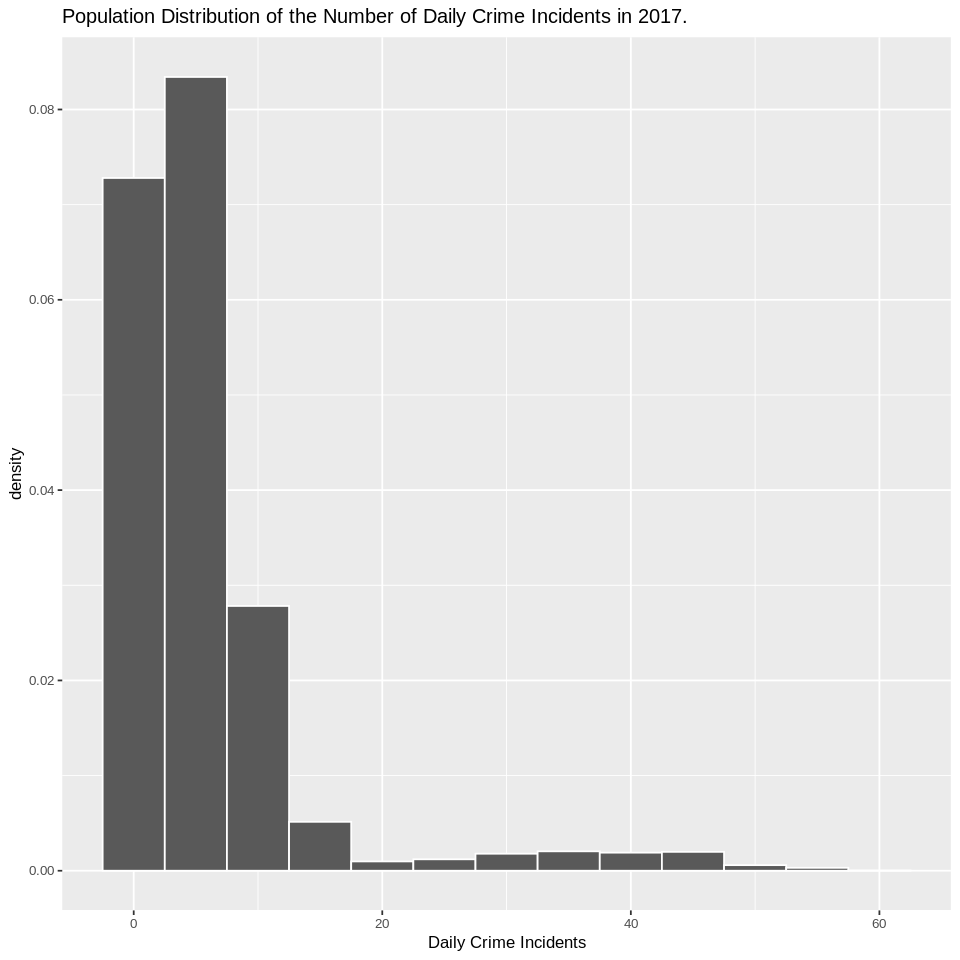

In [12]:
# visualization : population distribution
pop_dist <- crime_total %>%
    ggplot() + 
    geom_histogram(aes(x = total, y = ..density..), binwidth = 5, color="white") +
    theme(text = element_text(size = 10))+
    xlab("Daily Crime Incidents") +
    ggtitle("Population Distribution of the Number of Daily Crime Incidents in each year.")
pop_dist
# population distribution for 2017
pop_dist_2017 <- crime_total %>%
    filter(YEAR == 2017) %>%
    ggplot() + 
    geom_histogram(aes(x = total, y = ..density..), binwidth = 5, color="white") +
    theme(text = element_text(size = 10))+
    xlab("Daily Crime Incidents") +
    ggtitle("Population Distribution of the Number of Daily Crime Incidents in 2017.")
pop_dist_2017

## Method



  In this project, we thoroughly analyzed the average number of crime incidents across neighborhoods, months and years. There exists a noticeable difference in crime rate across the above variables. Specifically, a sharp decrease in crime rate since the beginning of COVID-19 in 2020 was found. But such findings are rudimentary and speculative in nature, we need more robust evidence to confidently conclude the observed difference in crime rate is meaningful. In order to make the project results trustworthy, we decided to carry out the following: 

1. An independent sample t-test in testing the average amount of crime incidents between year intervals 2017-2019 and 2020-2022 
 <br> $H_0$ : $\mu_{2017-2019}$ - $\mu_{2020-2022}$ = 0;
 <br> $H_1$ : $\mu_{2017-2019}$ - $\mu_{2020-2022}$ > 0;
2. Generate a confidence interval from bootstrapping and sampling distributions for the average crime incidents of 2017-2019 and 2020-2022;
3. Compare the result obtained from bootstrapping and sampling distribution

  In the final report, we expect to first provide robust evidence on whether crime rate has decreased since the start of COVID-19, then obtain a confidence interval for crime rate for the period 2020~2022. Such results would be informative for policy makers for this change in crime rate if later found to be long lasting. In fact, such results could lead to interesting follow up questions such as does the observed long term change in trend in criminal activity related to periods of economic downturn, if so would a reversal in trend be an indicator of economic recovery?
